In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets

## Minst

In [4]:
class Layer(object):

    def forward(self, x):
        pass

    def backward(self, dy):
        pass

    def update(self, lr=0.1):
        pass

In [5]:
class LinearLayer(Layer):

    def __init__(self, input, output) -> None:
        self.w = np.random.normal(
            loc=0.0,
            scale=pow(input, -0.5),
            size=(input, output)
        )
        self.dw = self.w * 0.1

    def forward(self, x):
        self.x = x
        y = np.dot(x, self.w)
        return y

    def backward(self, dy):
        dx = np.dot(dy, self.w.T)
        if dy.ndim == 1:
            self.dw = np.dot(self.x.reshape(-1, 1), dy.reshape(1, -1))
        else:
            self.dw = np.dot(self.x.T, dy)

        return dx

    def update(self, lr=0.1):
        self.w += lr * self.dw

In [6]:
class SigmoidLayer(Layer):

    def forward(self, x):
        # scipy.special.expit(x)
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, dy):
        dx = dy * (1.0 - self.y) * self.y
        return dx

In [7]:
class NeuralNetwork(object):

    def __init__(self, input, hidden, output) -> None:
        self.layers = [
            LinearLayer(input, hidden),
            SigmoidLayer(),
            LinearLayer(hidden, output),
            SigmoidLayer(),
        ]

    def forward(self, x: np.ndarray):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, dy):
        for layer in self.layers[::-1]:
            dy = layer.backward(dy)
        return dy

    def update(self, lr=0.1):
        for layer in self.layers[::-1]:
            layer.update(lr)

In [8]:
x_train, x_test, t_train, t_test = datasets.load_mnist()

In [9]:
net = NeuralNetwork(784, 73, 10)

In [10]:
np.seterr(all='ignore')

batch_size = 64
# train_size = (x_train.shape[0] // batch_size) * batch_size
train_size = batch_size * 300

x_train = x_train[0:train_size]
t_train = t_train[0:train_size]

epoch = 30

loss_list = []
acc_list = []

for e in range(epoch):

    bar = tqdm(range(int(train_size / batch_size)))

    bar.set_description(f'Epoch: {e}')

    indices = list(range(train_size))

    total = 0
    right = 0

    for _ in bar:
        if not indices:
            break
    
        batch_mask = np.random.choice(indices, batch_size, replace=False)
        for var in batch_mask:
            indices.remove(var)

        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        y = net.forward(x_batch)

        r = np.argmax(y, axis=1)

        total += x_batch.shape[0]
        right += np.sum(r == np.argmax(t_batch, axis=1))

        dy = t_batch - y
        loss = np.sum(dy ** 2)
        dx = net.backward(dy)
        net.update()

        acc = right / total * 100
        loss_list.append(loss)
        acc_list.append(acc)
        bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:0.3}%"))

Epoch: 29: 100%|██████████| 300/300 [00:16<00:00, 17.99it/s, loss=1.92, acc=98.9%] 


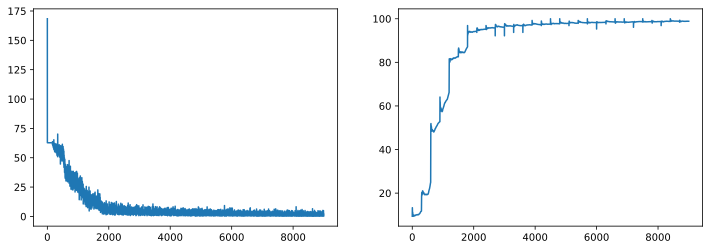

In [11]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [12]:
right = 0
total = 0

for i in range(x_test.shape[0]):
    x = x_test[i]
    t = t_test[i]
    y = net.forward(x)
    l = np.argmax(y)

    total += 1
    if l == np.argmax(t):
        right += 1

print("accuracy:", right / total * 100)


accuracy: 96.14285714285714
